# VST ATLAS

In [1]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.cross_validation import KFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from mclearn.active import ActiveLearner
from mclearn.classifier import grid_search_logistic
from mclearn.heuristics import (random_h, margin_h, entropy_h,
                                qbb_margin_h, qbb_kl_h,
                                pool_entropy_h, pool_variance_h)
from mclearn.preprocessing import balanced_train_test_split
from mclearn.tools import results_exist, load_results
from mclearn.viz import plot_class_distribution, plot_average_learning_curve
%matplotlib inline
plt.style.use('ggplot')

D:\Projects\Python\Anaconda3\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


We start by preparing the data and put it in an HDF5 Store.

In [107]:
sources = ['../data/vstatlas/lib_gal__AT.fits',
           '../data/vstatlas/lib_qso__AT.fits',
           '../data/vstatlas/lib_star_AT.fits',
           '../data/vstatlas/lib_WD___AT.fits']

classes = ['Galaxy', 'Quasar', 'Star', 'White Dwarf']

# a-priori likelihood for a random object in the sky
likelihoods = [6559. / 127. * 2496,
               2303. / 5. * 16,
               25602. / 697. * 14868,
               590. / 3. * 38]

dfs = []
sample = []

for source, obj in zip(sources, classes):
    data = fits.open(source)
    df = pd.DataFrame(data[1].data)
    df['class'] = obj
    dfs.append(df)
    sample.append(df.loc[0])
    
vstatlas = pd.concat(dfs, axis=0, ignore_index=True)
vstatlas = vstatlas[['class', 'rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']]
vstatlas = vstatlas.iloc[np.random.permutation(len(vstatlas))]
vstatlas = vstatlas.reset_index(drop=True)
vstatlas.to_hdf('data/vstatlas.h5', 'vstatlas')

samples = pd.DataFrame(sample)
samples = samples[['class', 'rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']]
samples = samples.reset_index(drop=True)
samples.to_hdf('../data/vstatlas_samples.h5', 'vstatlas_samples')

Let's now read in the data.

In [3]:
vstatlas = pd.read_hdf('../data/vstatlas.h5', 'vstatlas')
fig_dir = '../thesis/figures/'
target_col = 'class'
feature_cols = ['rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']

In [3]:
vstatlas.head()

,class,rmagC,umg,gmr,rmi,imz,rmw1,w1m2
0,Star,18.900099,2.527203,1.235399,0.541201,0.420200,0.430900,-0.725000
1,Star,19.546499,2.829502,1.442698,0.774500,0.558801,0.644199,-0.447201
2,Star,18.818100,0.952703,0.267597,0.033401,0.045199,-99.000000,-99.000000
3,Star,18.955101,1.006903,0.366797,0.140499,0.123499,-99.000000,-99.000000
4,Star,19.153099,3.097002,1.265000,0.431900,0.419700,0.045599,-0.903999


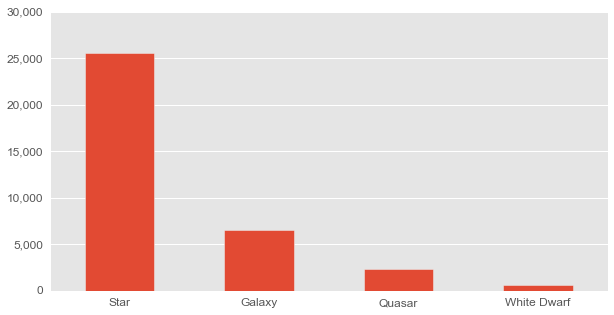

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = plot_class_distribution(vstatlas[target_col])
fig.savefig(fig_dir + 'bar_vstatlas_class_distribution.pdf', bbox_inches='tight')

In [5]:
25604 / 2303

11.117672600955276

In [4]:
vstatlas[target_col].value_counts()

Star           25604
Galaxy          6559
Quasar          2303
White Dwarf      590
dtype: int64

In [ ]:
# obtain a pool of 569*4 examples
X, _, y, _ = mclearn.balanced_train_test_split(
    vstatlas, feature_cols, target_col, train_size=589, test_size=1, random_state=2)
X, y = shuffle(X, y, random_state=14)

# scale data to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

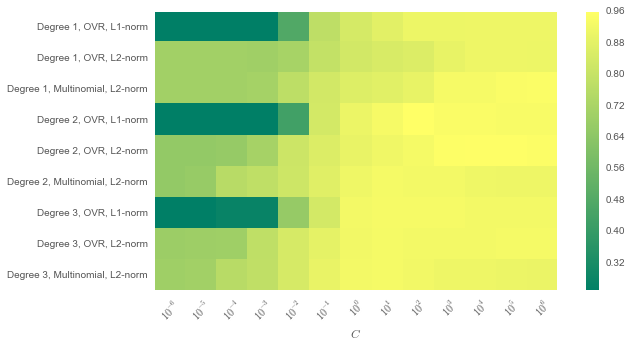

In [10]:
grid_search_logistic(X_scaled, y, train_size=1000, test_size=1000,
     fig_path=fig_dir+'heat_vstatlas_vgridsearch_logistic.pdf',
     pickle_path='../pickle/07_vstatlas/vstatlas_grid_scores_logistic.pickle')

In [4]:
# initialise the main classifier
logistic_classifier = LogisticRegression(multi_class='ovr', penalty='l1', C=100,
                                         random_state=2, class_weight='auto')
committee = BaggingClassifier(logistic_classifier, n_estimators=11, n_jobs=-1,
                              max_samples=300)

scaler = StandardScaler()
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)

X_scaled = scaler.fit_transform(vstatlas[feature_cols])
X_poly = transformer.fit_transform(X_scaled)
y = np.array(vstatlas[target_col])

# balance the training set
X_poly, _, y, _ = balanced_train_test_split(X_poly, y, train_size=2360, test_size=0)

kfold = StratifiedShuffleSplit(y, n_iter=5, test_size=0.3, train_size=0.7,
                               random_state=19)

## Active Learning Experiment

In [5]:
def run_active_learning_expt(heuristics, pickle_paths):
    for heuristic, pickle_path in zip(heuristics, pickle_paths):
        learning_curves = []
        for i, (train_index, test_index) in enumerate(kfold):
            X_train = X_poly[train_index]
            X_test = X_poly[test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            active_learner = ActiveLearner(classifier=logistic_classifier,
                                           heuristic=heuristic,
                                           initial_n=20,
                                           training_size=300,
                                           sample_size=300,
                                           verbose=True,
                                           committee=committee,
                                           committee_samples=300,
                                           pool_n=300,
                                           C=1)
            active_learner.fit(X_train, y_train, X_test, y_test)        
            learning_curves.append(active_learner.learning_curve_)
            print(i, end='')

        with open(pickle_path, 'wb') as f:
            pickle.dump(learning_curves, f, protocol=4) 

In [8]:
pickle_paths = ['../pickle/07_vstatlas/active_random.pickle',
                '../pickle/07_vstatlas/active_entropy.pickle',
                '../pickle/07_vstatlas/active_margin.pickle',
                '../pickle/07_vstatlas/active_qbb_margin.pickle',
                '../pickle/07_vstatlas/active_qbb_kl.pickle']

curve_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']

heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h]

if not results_exist(pickle_paths):
    run_active_learning_expt(heuristics, pickle_paths)

all_learning_curves = load_results(pickle_paths)

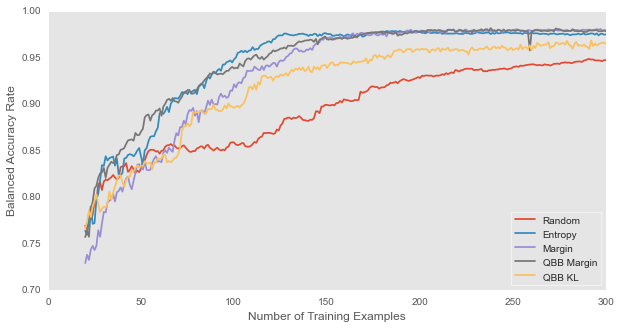

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = plot_average_learning_curve(np.arange(20, 301), all_learning_curves, curve_labels)

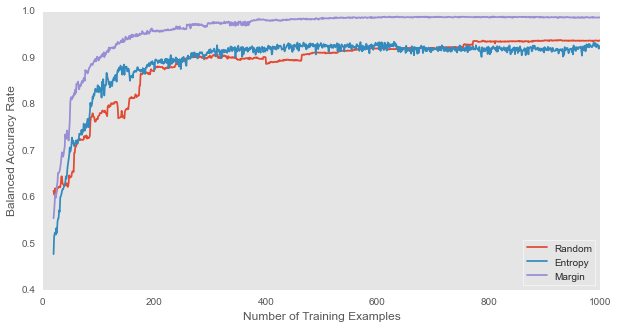

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(20, 1001), learning_curves, curve_labels)
fig.savefig(fig_dir+'lc_active_logistic_vstatlas.pdf', bbox_inches='tight')

## Warm start

In [14]:
# list of all heuristics to be used (and the paths where results are saved)
heuristics = [random_h]
curve_labels = ['Random']

pickle_paths = ['pickle/07_vstatlas/sgd_random_1.pickle']

scaler = StandardScaler()
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)

X_scaled = scaler.fit_transform(vstatlas[feature_cols])
X_poly = transformer.fit_transform(X_scaled)
y = np.array(vstatlas[target_col])

# balance the training set
X_poly, _, y, _ = balanced_train_test_split(X_poly, y, train_size=2360, test_size=0)

kfold = StratifiedShuffleSplit(y, n_iter=5, test_size=0.3, train_size=0.7,
                               random_state=19)

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
for heuristic, pickle_path in zip(heuristics, pickle_paths):
    learning_curves = []
    for train_index, test_index in kfold:
        #sgd = SGDClassifier(loss='log', penalty='l2', class_weight='auto', n_iter=100, n_jobs=-1,
        #            fit_intercept=True, warm_start=True, alpha=0.0001, random_state=13)
        sgd = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        
        training_pool = X_poly[train_index]
        testing_pool = X_poly[test_index]
        training_oracle = y[train_index]
        testing_oracle = y[test_index]
        
        active_learner = ActiveLearner(classifier=sgd,
                                       heuristic=heuristic,
                                       initial_n=100,
                                       training_size=1000,
                                       sample_size=len(y),
                                       verbose=True,
                                       committee=committee)
        active_learner.fit(training_pool, training_oracle, testing_pool, testing_oracle)        
        learning_curves.append(active_learner.learning_curve_)
    print('\n')
    
    with open(pickle_path, 'wb') as f:
        pickle.dump(learning_curves, f, protocol=4) 

Average of 11 iterations

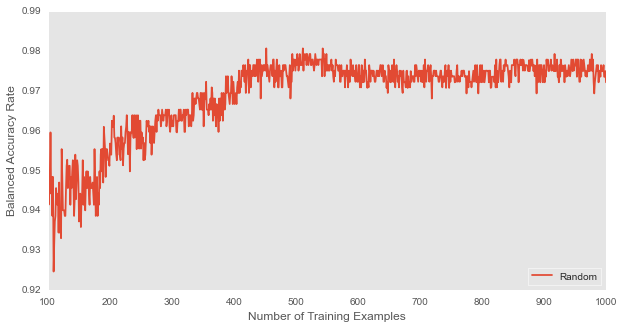

In [24]:
fig = plt.figure(figsize=(10, 5))
ax = plot_average_learning_curve(np.arange(100, 1001), [learning_curves], ['Random'])

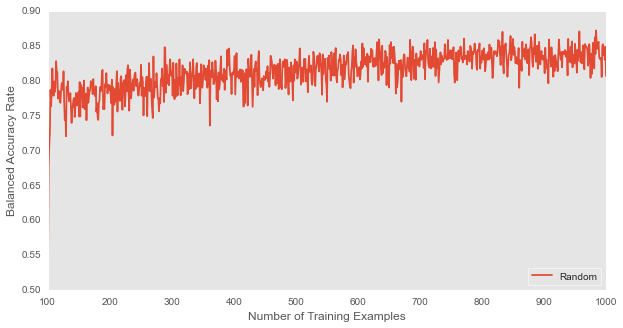

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(100, 1001), [learning_curves], ['Random'])